In [58]:
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoTokenizer, AutoModel
import yaml

from utils import add_attr_interface
from zero_shot import do_zero_shot
from metrics import compute_metrics, visualize_similarity_distrib

# Data loading

In [53]:
DATASET_ROOT_DIR = "../data/"
dataset_path = os.path.join(DATASET_ROOT_DIR, "dataset_big_patent_v1.json")

In [54]:
# Loading dataset
with open(dataset_path, "r") as json_file:
    dataset = json.load(json_file)

df = pd.DataFrame(dataset)
df.head()


,query,negative,pos
0,What are the key advantages and applications o...,The present technology introduces an innovativ...,RELATED APPLICATIONS This application claims t...
1,How does a magnetic energy harvester operate w...,The advanced energy accumulation equipment bei...,RELATED APPLICATIONS This application claims t...
2,How does an energy harvester operate without a...,The invention relates to the design and utilit...,RELATED APPLICATIONS This application claims t...
3,How can buffer blocks for ruminant animals be ...,The innovative technique pertains to mineral s...,BACKGROUND OF THE INVENTION I. Field of the In...
4,What advancements does the described patent pr...,The current text discusses a novel mechanical ...,RELATED APPLICATION The present application cl...


# Data analysis

## Dataset structure

In [43]:
print(f"Number of samples in dataset: {len(dataset)}")

Number of samples in dataset: 499


#### Study length distributions of entries

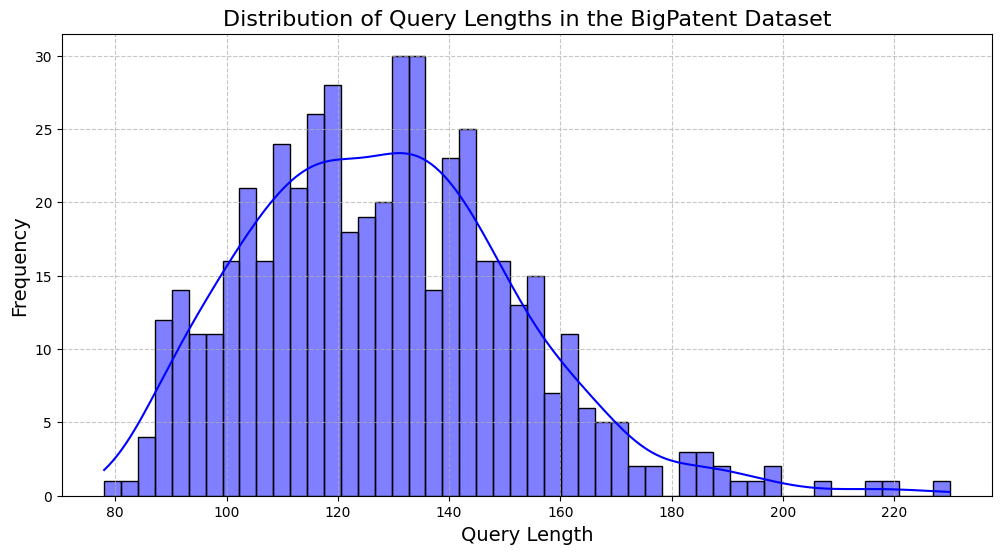

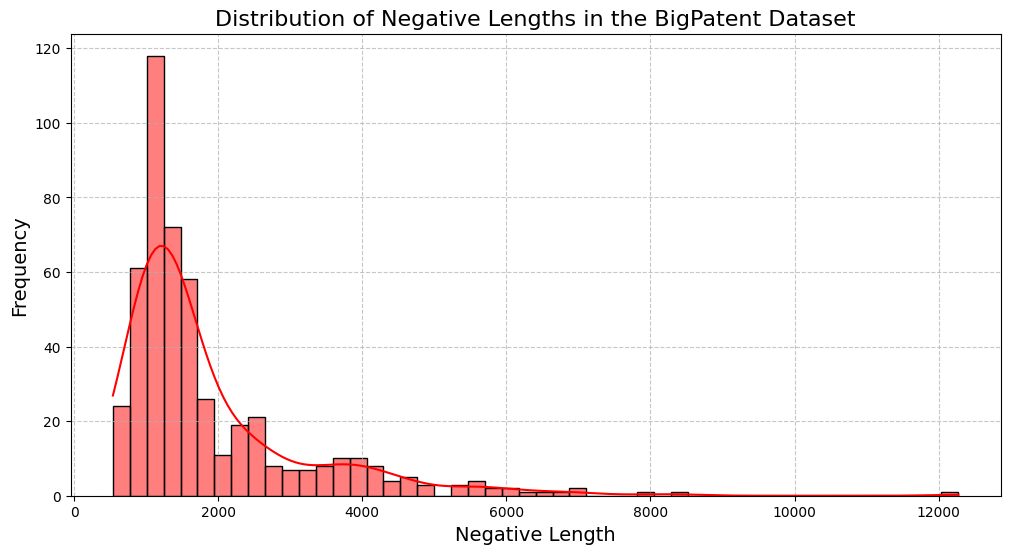

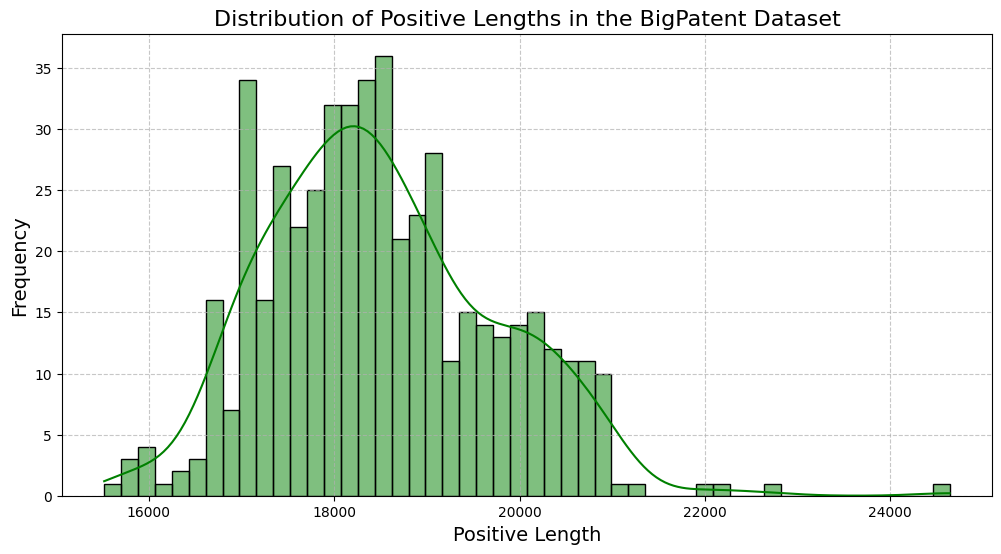

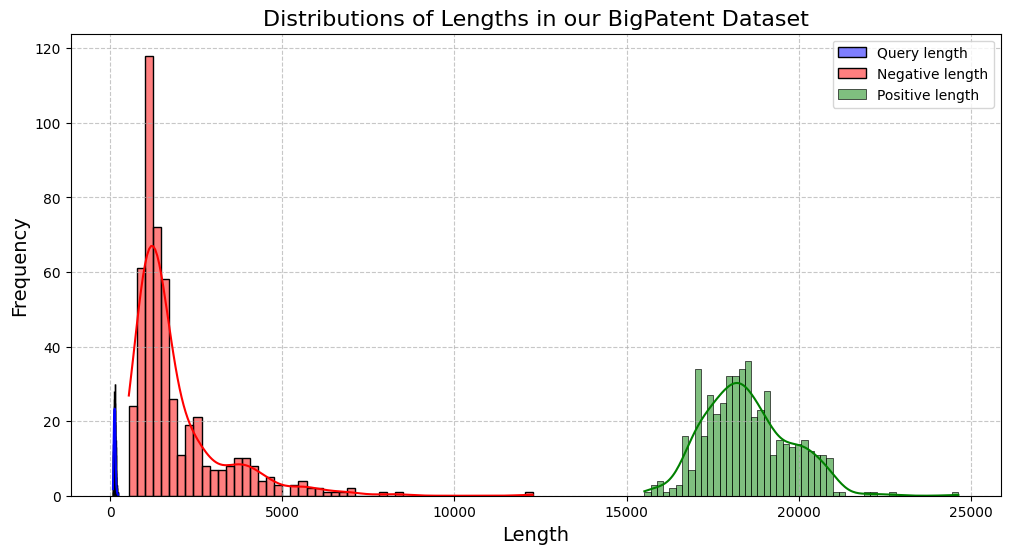

In [44]:
# Queries
plt.figure(figsize=(12, 6))
sns.histplot(df['query'].apply(len), bins=50, color='blue', label='Query length', kde=True)
plt.title('Distribution of Query Lengths in the BigPatent Dataset', fontsize=16)
plt.xlabel('Query Length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Negatives
plt.figure(figsize=(12, 6))
sns.histplot(df['negative'].apply(len), bins=50, color='red', label='Negative length', kde=True)
plt.title('Distribution of Negative Lengths in the BigPatent Dataset', fontsize=16)
plt.xlabel('Negative Length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Positives
plt.figure(figsize=(12, 6))
sns.histplot(df['pos'].apply(len), bins=50, color='green', label='Positive length', kde=True)
plt.title('Distribution of Positive Lengths in the BigPatent Dataset', fontsize=16)
plt.xlabel('Positive Length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# All distribs at once
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.histplot(df['query'].apply(len), bins=50, color='blue', label='Query length', kde=True)
sns.histplot(df['negative'].apply(len), bins=50, color='red', label='Negative length', kde=True)
sns.histplot(df['pos'].apply(len), bins=50, color='green', label='Positive length', kde=True)
plt.title('Distributions of Lengths in our BigPatent Dataset', fontsize=16)
plt.xlabel('Length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

#### Word Frequency

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: matlabengineforpython R2022a has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of matlabengineforpython or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\YBT1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\YBT1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Most common words in queries: [('featur', 101), ('patent', 90), ('method', 86), ('improv', 84), ('innov', 75), ('describ', 73), ('devic', 69), ('use', 61), ('design', 57), ('system', 52), ('offer', 51), ('novel', 49), ('applic', 47), ('invent', 47), ('new', 46), ('advanc', 40), ('apparatu', 37), ('enhanc', 34), ('provid', 32), ('treatment', 29)]
Most common words in negatives: [('system', 767), ('devic', 680), ("'s", 648), ('design', 608), ('includ', 561), ('invent', 525), ('use', 508), ('mechan', 475), ('within', 399), ('structur', 389), ('compon', 366), ('specif', 357), ('enhanc', 344), ('process', 342), ('innov', 336), ('variou', 336), ('element', 323), ('oper', 321), ('applic', 321), ('method', 315)]
Most common words in positives: [('fig', 9122), ('invent', 7852), ('may', 6838), ('use', 6790), ('embodi', 4840), ('present', 4566), ('includ', 4460), ('provid', 4252), ('devic', 4246), ('one', 4186), ('show', 4077), ('1', 3987), ('2', 3578), ('first', 3520), ('prefer', 3425), ('end', 

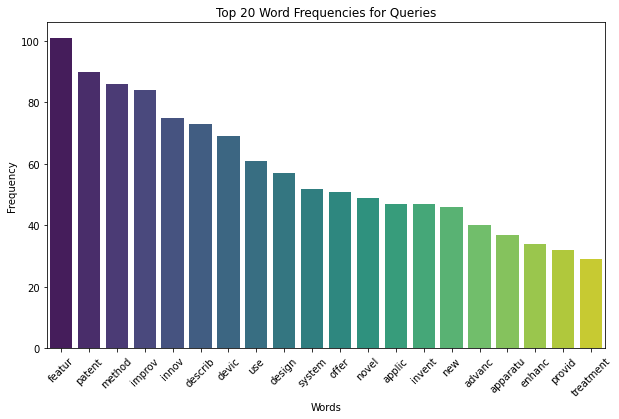

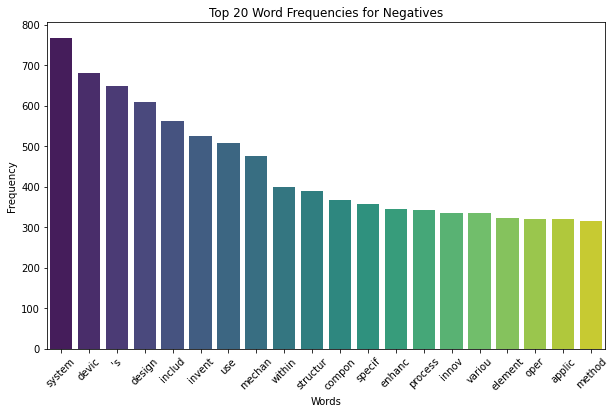

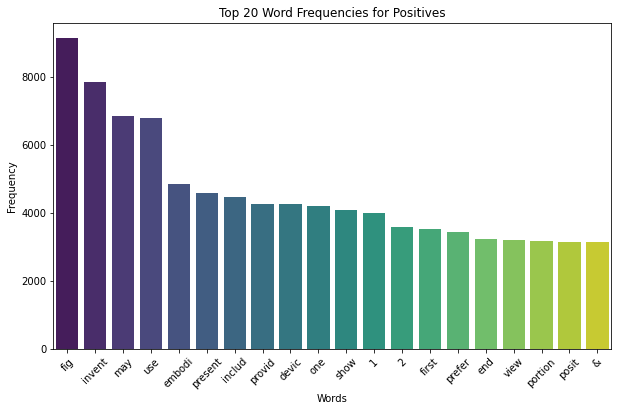

In [16]:
nltk.download('stopwords')
nltk.download('wordnet')
punctuations = ['.', ',', '?', '!', ';', '(', ')', '[', ']', '#', '/']
stop_words = set(stopwords.words('english'))

def remove_stop_words(text):
    words = word_tokenize(text)
    filtered_text = [word for word in words if word.lower() not in stop_words and word.lower() not in punctuations]
    return ' '.join(filtered_text)

def stem_words(text, stemmer):
    words = word_tokenize(text)
    stemmed_text = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_text)

def lemmatize_words(text, lemmatizer):
    words = word_tokenize(text)
    lemmatized_text = [lemmatizer.lemmatize(word, wordnet.VERB) for word in words]
    return ' '.join(lemmatized_text)

def get_most_common_words(texts, num_words=20):
    all_words = [word.lower() for text in texts for word in word_tokenize(text)]
    word_freq = Counter(all_words)
    return word_freq.most_common(num_words)

# Remove stop words, then apply stemming and lemmatization
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
for column in df:
    df[column] = df[column].apply(remove_stop_words)
    df[column] = df[column].apply(stem_words, args=[stemmer])
    df[column] = df[column].apply(lemmatize_words, args=[lemmatizer])


most_common_query = get_most_common_words(df['query'].tolist())
most_common_negative = get_most_common_words(df['negative'].tolist())
most_common_positive = get_most_common_words(df['pos'].tolist())
print("Most common words in queries:", most_common_query)
print("Most common words in negatives:", most_common_negative)
print("Most common words in positives:", most_common_positive)

# Separate words and their frequencies for plotting
words_query, counts_query = zip(*most_common_query)
words_negative, counts_negative = zip(*most_common_negative)
words_positive, counts_positive = zip(*most_common_positive)

# Create a DataFrame for Seaborn
df_query_freq = pd.DataFrame(most_common_query, columns=['Query_words', 'Frequency'])
df_negative_freq = pd.DataFrame(most_common_negative, columns=['Negative_words', 'Frequency'])
df_positive_freq = pd.DataFrame(most_common_positive, columns=['Positive_words', 'Frequency'])

# Plot the bar chart using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Query_words', y='Frequency', data=df_query_freq, palette='viridis')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Word Frequencies for Queries')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Negative_words', y='Frequency', data=df_negative_freq, palette='viridis')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Word Frequencies for Negatives')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Positive_words', y='Frequency', data=df_positive_freq, palette='viridis')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Word Frequencies for Positives')
plt.xticks(rotation=45)
plt.show()

#### TF-IDF

Top 20 words by TF-IDF score: [('devic', 0.08864061042727174), ('invent', 0.08634937585483955), ('use', 0.08301519497922713), ('design', 0.06772767032705934), ('fig', 0.06593179234719841), ('method', 0.06434652851616304), ('includ', 0.05410589512014565), ('applic', 0.054038412530175335), ('provid', 0.05241424542403075), ('present', 0.04989153185904045), ('describ', 0.049300391427059526), ('apparatu', 0.04860102845595691), ('patient', 0.04679795676888026), ('mechan', 0.044761015816607796), ('process', 0.04325741689015558), ('composit', 0.042854448708653146), ('compound', 0.04133148461325939), ('activ', 0.04059242369846575), ('structur', 0.03909282767609547), ('materi', 0.038661406771593534)]


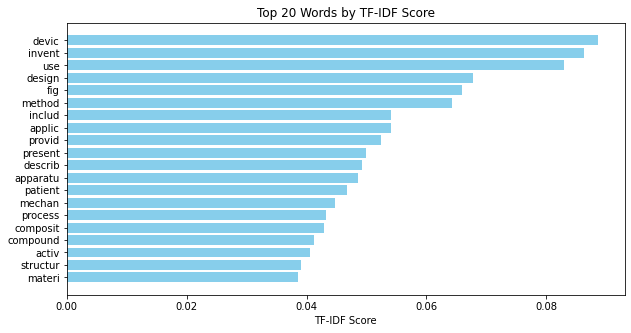

In [ ]:
# Combine all texts for TF-IDF calculation
all_texts = df['query'].tolist() + df['negative'].tolist() + df['pos'].tolist()

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
tfidf_matrix = tfidf_vectorizer.fit_transform(all_texts)

# Get feature names (words) and their TF-IDF scores
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.mean(axis=0).tolist()[0]
tfidf_scores = list(zip(feature_names, tfidf_scores))
tfidf_scores.sort(key=lambda x: x[1], reverse=True)

# Display top 20 words by TF-IDF score
print("Top 20 words by TF-IDF score:", tfidf_scores[:20])

# Extract top 20 words by TF-IDF score for bar chart
top_words = tfidf_scores[:20]
words, scores = zip(*top_words)

plt.figure(figsize=(10, 5))
plt.barh(words, scores, color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel('TF-IDF Score')
plt.title('Top 20 Words by TF-IDF Score')
plt.show()

# Zero-shot performances

In [55]:
cfg_path = "./config.yml"
model_name = "infgrad/stella-base-en-v2"  # sentence-transformers/all-mpnet-base-v2
batch_size = 16
device = 'cuda:0'

# Load config
with open(cfg_path, 'r') as yml_file:
    cfg = add_attr_interface(yaml.safe_load(yml_file))
    
# Load test dataset (reload data to avoid word frequency analysis impact)
with open(split_path, 'rb') as pkl_file:
    test_indices = pickle.load(pkl_file)['test_indices']
with open(dataset_path, "r") as json_file:
    dataset = json.load(json_file)
df = pd.DataFrame(dataset)
df_test = df.iloc[test_indices]

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cfg.TRAIN.MODEL_CACHE_DIR)
model = AutoModel.from_pretrained(model_name, cache_dir=cfg.TRAIN.MODEL_CACHE_DIR)

In [57]:
query_embeddings, positive_embeddings, negative_embeddings = do_zero_shot(tokenizer, model, df_test, batch_size, device)

TypeError: do_zero_shot() takes 4 positional arguments but 5 were given

In [27]:
metrics = compute_metrics(query_embeddings, positive_embeddings, negative_embeddings)
print("metrics = \n", metrics)

MRR Score: 0.6465921449332697
Accuracy: 0.6312625250501002
metrics = 
 {'pos_similarities': array([0.75859416, 0.6908503 , 0.7265941 , 0.8110252 , 0.8280977 ,
       0.7273632 , 0.809621  , 0.8433467 , 0.8034755 , 0.81753397,
       0.8359048 , 0.7731736 , 0.7156042 , 0.8428421 , 0.7967411 ,
       0.78083205, 0.80645895, 0.77620506, 0.79961133, 0.75580317,
       0.817863  , 0.80487156, 0.74151754, 0.6969315 , 0.7907825 ,
       0.84259206, 0.74934626, 0.7473006 , 0.74366444, 0.7875153 ,
       0.8421369 , 0.823052  , 0.7915886 , 0.72444844, 0.7993368 ,
       0.7950939 , 0.77929616, 0.72859466, 0.7766625 , 0.7253386 ,
       0.77283293, 0.79659307, 0.71262693, 0.72583216, 0.733855  ,
       0.6786964 , 0.86543834, 0.7459854 , 0.84084195, 0.7545042 ,
       0.73970824, 0.7782284 , 0.7565787 , 0.70865333, 0.75925195,
       0.82053196, 0.7293846 , 0.7647271 , 0.8009649 , 0.73883075,
       0.6906593 , 0.66950405, 0.7362628 , 0.8216481 , 0.67235005,
       0.7647015 , 0.7915302 , 0.7846

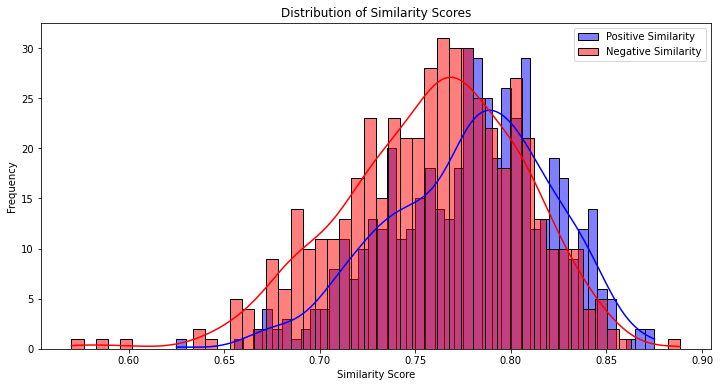

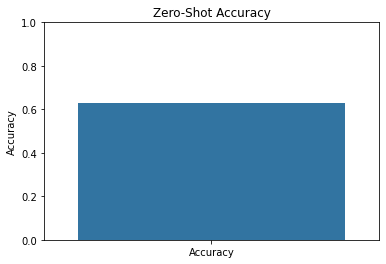

In [29]:
visualize_similarity_distrib(metrics)

# Fined-tuned model performances

In [59]:
import json
import numpy as np
import pandas as pd
import pickle
from transformers import AutoTokenizer, AutoModel
data_path = "../data/dataset_big_patent_v1.json"  
split_path = "../data/indices_split.pkl"
model_path = "../outputs/2024_06_13-15h13_stella-base-en-v2/models"  
model_name = "infgrad/stella-base-en-v2"

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_path)

# Load test dataset
with open(split_path, 'rb') as pkl_file:
    test_indices = pickle.load(pkl_file)['test_indices']
query_list = [dataset[idx] for idx in test_indices]

with open(data_path, 'r') as json_file:
    dataset = json.load(json_file)
df = pd.DataFrame(dataset)
test_df = df.iloc[test_indices]

In [ ]:
query_embeddings, positive_embeddings, negative_embeddings = do_zero_shot(tokenizer, model, test_df, batch_size=8)


[do_zero_shot] - Processing query embeddings...
[get_embeddings] - processing batch n°1/7...
[get_embeddings] - processing batch n°2/7...
[get_embeddings] - processing batch n°3/7...
[get_embeddings] - processing batch n°4/7...
[get_embeddings] - processing batch n°5/7...
[get_embeddings] - processing batch n°6/7...
[get_embeddings] - processing batch n°7/7...

[do_zero_shot] - Processing positives embeddings...
[get_embeddings] - processing batch n°1/7...
[get_embeddings] - processing batch n°2/7...
[get_embeddings] - processing batch n°3/7...
[get_embeddings] - processing batch n°4/7...
[get_embeddings] - processing batch n°5/7...
[get_embeddings] - processing batch n°6/7...


In [29]:
metrics = compute_metrics(query_embeddings, positive_embeddings, negative_embeddings)
metrics

MRR Score: 1.0
Accuracy: 1.0


{'pos_similarities': array([0.7290422 , 0.8406439 , 0.77673584, 0.7205074 , 0.75343966,
        0.7518139 , 0.7174047 , 0.7594673 , 0.70521665, 0.7766215 ,
        0.77092975, 0.7442481 , 0.79856926, 0.7575788 , 0.73640215,
        0.84190917, 0.85065997, 0.80163085, 0.73355603, 0.7984557 ,
        0.82929546, 0.8170384 , 0.7306974 , 0.8131385 , 0.8066007 ,
        0.7816743 , 0.75842834, 0.7865081 , 0.7844782 , 0.797645  ,
        0.7686225 , 0.7400354 , 0.73597276, 0.80621606, 0.7558881 ,
        0.7626257 , 0.84941053, 0.8286195 , 0.8184657 , 0.79449195,
        0.8100426 , 0.80633926, 0.6933292 , 0.73072016, 0.70628977,
        0.73209417, 0.78813696, 0.7445157 , 0.84228593, 0.6656395 ],
       dtype=float32),
 'neg_similarities': array([0.62688005, 0.5851434 , 0.678686  , 0.56476307, 0.6557007 ,
        0.6840105 , 0.5246891 , 0.6782999 , 0.5671538 , 0.53883666,
        0.5878126 , 0.59109896, 0.57492787, 0.5170863 , 0.5208923 ,
        0.63935304, 0.71854407, 0.45179725, 0.631965

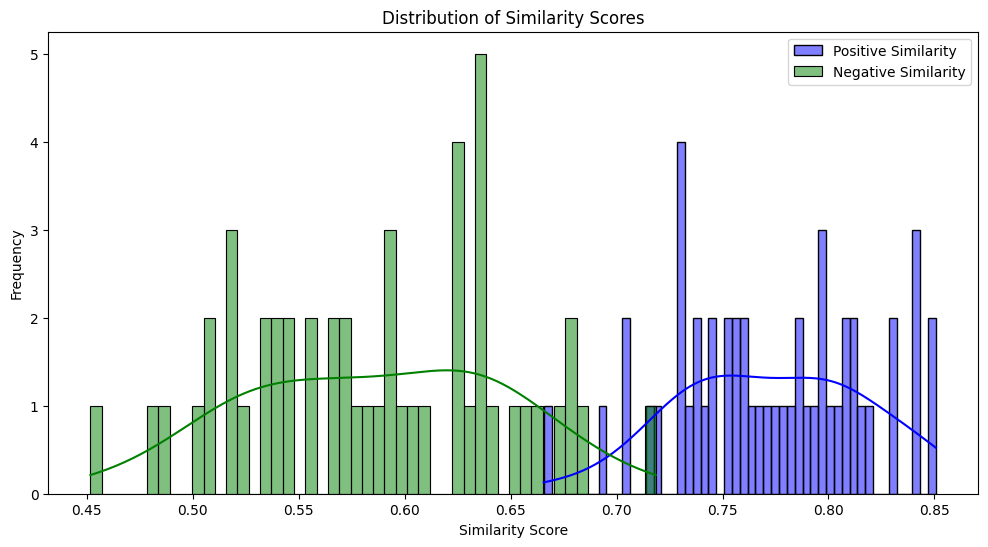

In [30]:
visualize_similarity_distrib(metrics)